In [279]:
import numpy as np
%matplotlib inline
# standard-ish Qiskit libraries
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, Aer, IBMQ
#import qiskit as qk

# about transpiling, compiling, and executing
from qiskit.compiler import transpile

# For graphs
from qiskit.tools.jupyter import *
from qiskit.visualization import *

# Aer noise models
from qiskit.providers.aer import noise
import pygsti as py
import itertools

# Ignis models
from qiskit.ignis.verification.randomized_benchmarking import clifford_utils
from qiskit.converters import circuit_to_dag, dag_to_circuit

from qiskit import *
from qiskit.extensions.simulator import *
from qiskit.ignis.verification.randomized_benchmarking import Clifford

Note that the project is still on-going and some parts of the code is still using the pygsti package.

# Tradational Randomize Benchmarking (do up to 2 qubits)

In [294]:
from IPython.display import Image

In traditional randomize benchmarking, also known as Clifford Randomized Benchmarking (CRB), the qubits initialized in zero computational basis $| 0 \rangle ^{\otimes n}$ (where $n$ is a number of qubits we want to benchmark) is evolved with many layers of random clifford gates (up to $m$ layers and denote $U_m$ as the unitary evolution of this part), and then, the circuit is inverted by the the inversed unitary $U_m^\dagger$ to produce $|\psi_{2m}\rangle$. The outcome is measured and counted as a success or a failure (success if $|\psi_{2m}\rangle$ and failure otherwise). By repeating this procedure many times, the probability of success can be calculated and used to estimate error of $n-$qubit gate.

There are two problems with this protocal for scaling with large number of qubits. (i) the size of one- and two-qubit clifford gate for large $n$ is huge when decomposed into 1 and 2 clifford gates. (ii) the inverse circuit is also large.

In an usual benchmarking routine in the current quantum devices, errors can be estimated up to two qubit gate ($n = 2$). The $n-$qubit gate error cannot be calculated by only one- and two-qubit gate errors due to an exclusion of correlated errors. Thus, the real performance of the whole $n-$qubit device is usually much worse than the prediction by using these one- and two-qubit errors. 

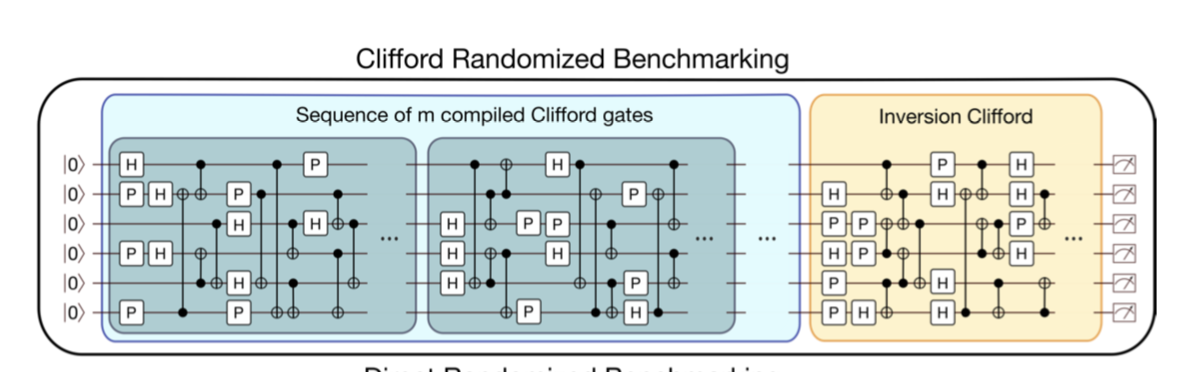

In [295]:
Image("Screenshot 2019-10-12 at 5.16.14 PM.png")

# Direct Randomized Benchmarking

The Direct Randomized Benchmarking (from the paper [1] TJ Proctor, A Carignan-Dugas, K Rudinger, E Nielsen, R Blume-Kohout, K Young, Direct randomized benchmarking for multi-qubit devices Phys. Rev. Lett. 123, 030503 (2019)) is a new protocal proposed to benchmark multi-qubit performance (so, we can do $n>2$).

The protocal consits of three parts:
    1. creating a random stabilizer.
    2. randomly pick native gates for $


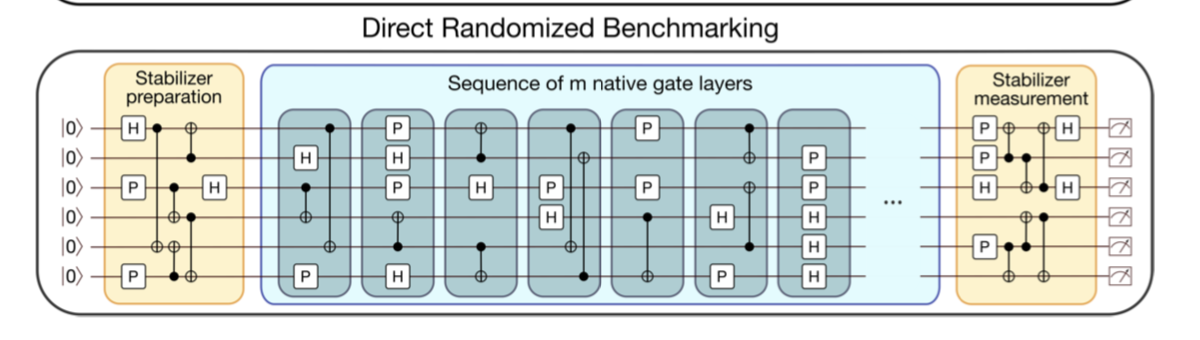

In [296]:
Image("Screenshot 2019-10-12 at 5.16.23 PM.png")

In [280]:
def random_stabilizer(n):
    """ n = number of qubits and return a random stabilizer"""
    
    aa = py.tools.random_clifford(n)
    pspec = py.objects.ProcessorSpec(n, ['Gh', 'Gp', 'Gcnot'])
    circuit = py.algorithms.compile_clifford(aa[0], aa[1], pspec=pspec)
    
    tmp = circuit.convert_to_openqasm(block_between_layers=False)
    tmp = tmp.replace('id', 'u1(0)')
    
    qc = QuantumCircuit.from_qasm_str(tmp)
    
    dag = circuit_to_dag(qc)
    dag.remove_all_ops_named("measure")
    qc = dag_to_circuit(dag)
    
    qc = transpile(qc,basis_gates=['u1','h','s','sdg','x','y','z', 'cx','v','w','cz','swap'])
    #qc = transpile(qc, optimization_level=3) #, basis_gates=['u3', 'cx'])

    return qc

In [281]:
def native_gate(qc,m,n,p_cnot):
    for i in range(m):
        cnot_accept = np.random.rand(1)
        if p_cnot > cnot_accept:
            cnot_pair = np.arange(n)
            np.random.shuffle(cnot_pair) #pick 2 randomly
            qc.cx(cnot_pair[0],cnot_pair[1]) #apply cnot between two
            for j in range(2,n):
                c1 = clifford_utils.random_clifford_gates(1)
                instr = clifford_utils.get_quantum_circuit(c1,1)
                if len(instr) > 0:
                    qc.append(instr, [cnot_pair[j]])
                
        else:
            for j in range(n):
                c1 = clifford_utils.random_clifford_gates(1)
                instr = clifford_utils.get_quantum_circuit(c1,1)
                if len(instr) > 0:
                    qc.append(instr,[j])
                
    #qc = transpile(qc, optimization_level=3, basis_gates=['id','h','s','sdg','x','y','z', 'cx'])
    #qc = transpile(qc, optimization_level=3, basis_gates=['u3', 'cx'])
    qc = transpile(a, basis_gates=['u1','h','s','sdg','x','y','z', 'cx','v','w','cz','swap'])
    return qc

In [282]:
def circ_to_sym(qc):
    qc.snapshot("final", snapshot_type = "stabilizer")
    result = execute(qc, Aer.get_backend("qasm_simulator")).result()
    cliff_dict =result.data(0)['snapshots']['stabilizer']['final'][0]
    cliff = Clifford.from_dict(cliff_dict)
    
    table_c = np.multiply(cliff._table,1)
    phase_c = np.multiply(cliff._phases,1)
    return table_c, phase_c

In [283]:
number_qubit = 4

In [284]:
a = random_stabilizer(number_qubit)
ng = native_gate(a,6,number_qubit,0.75)
scomp = circ_to_sym(ng)


No measurements in circuit "circuit627": count data will return all zeros.


In [285]:
pspec = py.objects.ProcessorSpec(number_qubit, ['Gh', 'Gp', 'Gcnot'])
pmes = py.tools.random_phase_vector(scomp[0], number_qubit)

cinv = py.algorithms.compile_stabilizer_measurement(scomp[0],pmes,pspec)

tmpinv = cinv.convert_to_openqasm(block_between_layers=False)
tmpinv = tmpinv.replace('id', 'u1(0)')

qcinv = QuantumCircuit.from_qasm_str(tmpinv)

qcinv.draw()

In [286]:
for i in range(number_qubit):
    ng.h([i])

In [287]:
full2 = ng + qcinv

In [289]:
dag3 = circuit_to_dag(full2)
dag3.remove_all_ops_named("measure")
full2 = dag_to_circuit(dag3)

for i in range(number_qubit):
    full2.h([i])
    
for i in range(number_qubit):
    full2.measure([i],[i])

In [290]:
full2.draw()

In [291]:
job2 = execute(full2,Aer.get_backend("qasm_simulator"),shots=10000)

In [292]:
count2 = job2.result().get_counts(full2)

In [293]:
count2

{'0111': 1220,
 '1000': 1306,
 '1100': 1254,
 '0011': 1241,
 '0110': 1223,
 '1101': 1240,
 '0010': 1256,
 '1001': 1260}